In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format


### **가설 - 거래량이 종종 터지며, 매집의 흔적을 보인다.**

양봉이면서 거래량이 갑자기 증가하는 날을 카운트하고, 수익율과의 상관관계를 보겠습니다.

In [2]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head()

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
date,,,,,,,,,,,,,,,,,
2021-01-04,2185,2320,2135,2260,588133,0.044,060310,3S,NaN,NaN,0,0.996,1.013,1.013,0.993,0.962,1.013
2021-01-05,2270,2285,2200,2250,410263,-0.004,060310,3S,1.008,0.996,0,1.018,1.018,0.998,0.967,0.971,1.018
2021-01-06,2225,2310,2215,2290,570349,0.018,060310,3S,0.996,1.018,1,1.000,0.980,0.950,0.954,0.950,1.000
2021-01-07,2290,2340,2240,2290,519777,0.000,060310,3S,1.008,1.000,0,0.980,0.950,0.954,0.950,0.959,0.980
2021-01-08,2300,2315,2225,2245,462568,-0.020,060310,3S,0.999,0.980,0,0.969,0.973,0.969,0.978,0.973,0.978


In [14]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_4 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    data['volume_mean'] = data['volume'].rolling(60).mean()
    data['volume_std'] = data['volume'].rolling(60).std()
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std'] # 거래량은 종목과 주가에 따라 다르기 떄문에 표준화한 값이 필요함
    data['z>1.96'] = (data['close'] > data['open'])*(data['volume_z'] > 1.65).astype(int) # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날
    data['num_z>1.96'] =  data['z>1.96'].rolling(60).sum()  # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날을 카운트
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['volume_mean','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data_all_4 = pd.concat([data, data_all_4], axis=0)

data_all_4.to_pickle('data_all_4.pkl')  

<br> 거래량이 갑자기 많아지고 양봉인 날을 카운트하고 그 갯 수에 따라 수익율의 변화를 봤습니다. 전체적으로 거래량이 갑자기 증가하는 날이 많을 수 록 수익율이 증가하는 패턴을 보여줍니다. 결과의 마지막 num_z 가 15일인 경우는 수익율이 급강하했는데요. 실제로 너무 많으면 수익율이 안 좋은 것인지 여부는 해당 레코드 수(47개)가 많지 않아 신뢰하기 어렵습니다.  

         count  mean
num_z               
0.000   106382 1.027
1.000    79398 1.031
2.000    58093 1.032
3.000    39771 1.035
4.000    25309 1.036
5.000    15557 1.038
6.000     9362 1.039
7.000     4782 1.045
8.000     3263 1.048
9.000     1513 1.044
10.000     906 1.047
11.000     452 1.046
12.000     318 1.035
13.000      56 1.046
14.000      94 1.048
15.000      47 1.002


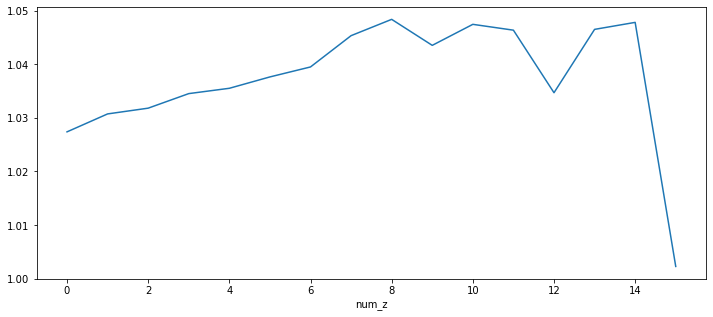

In [15]:
data_all_4 = pd.read_pickle('data_all_4.pkl') 
data_all_4.groupby('num_z>1.96')['max_close'].mean().plot(figsize=(12,5))
print(data_all_4.groupby('num_z>1.96')['max_close'].agg(['count','mean']))